# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Knn" data-toc-modified-id="Knn-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Knn</a></div><div class="lev1 toc-item"><a href="#Keras" data-toc-modified-id="Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Keras</a></div>

In [84]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
import pickle
from sklearn import preprocessing
from scipy import spatial
import sklearn

import matplotlib.pyplot as plt

In [2]:
# with open('homegate_purchall.json', 'r') as f:
#     r = f.read()
# data = json.loads(r)

In [29]:
# dfs = []
# for item in data['items']:
#     dfs.append(pd.DataFrame(item).drop_duplicates(subset=['advertismentId']))
# df = pd.concat(dfs)
# df.to_csv('homegate.csv', index=False)

In [4]:
%matplotlib inline

In [34]:
df = pd.read_csv('homegate.csv')
df['norm_price'] = df['price']/df['surfaceLiving']
df = df.drop_duplicates()
df['Lon'] = df.geoLocation.apply(lambda x: x.split(',')[0])
df['Lat'] = df.geoLocation.apply(lambda x: x.split(',')[1])
df.Lat = df.Lat.apply(float)
df.Lon = df.Lon.apply(float)
df = df[df.Lat > 20]

In [6]:
import matplotlib.pyplot as plt

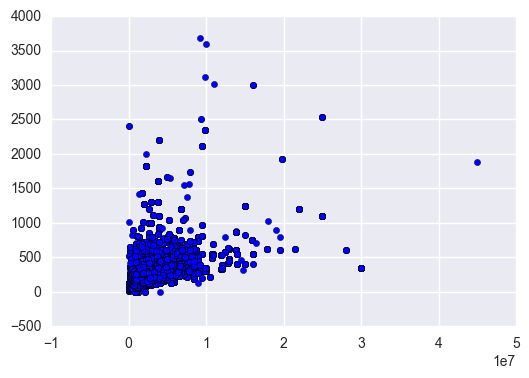

In [7]:
plt.figure()
x, y = df['price'].values, df['surfaceLiving'].values
plt.scatter(x,y);

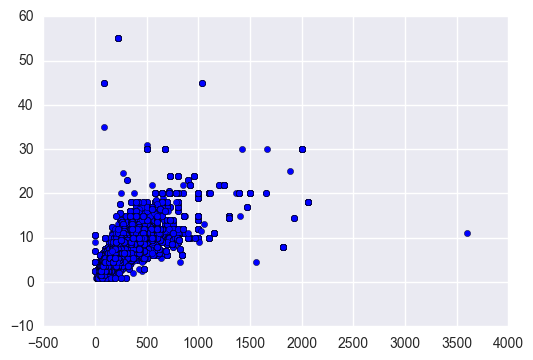

In [8]:
x, y = df['surfaceLiving'].values, df['numberRooms'].values
sns.plt.scatter(x,y)

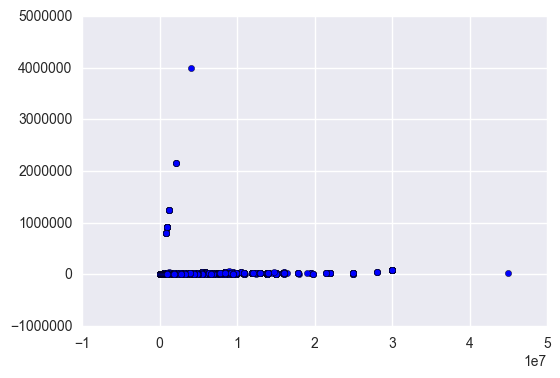

In [9]:
plt.figure()
valid = df.dropna(subset=['price','surfaceLiving'])
x, y = valid['price'].values, (valid['price']/valid['surfaceLiving']).values
sns.plt.scatter(x,y);

In [35]:
feature_names = ['agencyId', 'surfaceLiving', 'numberRooms', 'city', 'advertisementId']
label_names = ['price']
label_namesb = ['norm_price']

In [39]:
le = preprocessing.LabelEncoder()
le.fit(df['geoLocation'].values)
df['geo'] = le.transform(df['geoLocation'].values)

In [198]:
sub = df.dropna(subset=['norm_price','surfaceLiving'])[feature_names+['geo','geoLocation']+label_names+label_namesb]
sub.dropna().to_csv('geoLoc.csv')

In [199]:
from numpy import sin,cos,arctan2,sqrt,pi
EARTHRADIUS = 6371.0

def getDistanceByHaversine(loc1, loc2):
    '''Haversine formula - give coordinates as a 2D numpy array of
    (lat_denter link description hereecimal,lon_decimal) pairs'''
    #      
    # "unpack" our numpy array, this extracts column wise arrays
    lat1 = float(loc1[1])
    lon1 = float(loc1[0])
    lat2 = float(loc2[1])
    lon2 = float(loc2[0])
    #
    # convert to radians ##### Completely identical
    lon1 = lon1 * pi / 180.0
    lon2 = lon2 * pi / 180.0
    lat1 = lat1 * pi / 180.0
    lat2 = lat2 * pi / 180.0
    #
    # haversine formula #### Same, but atan2 named arctan2 in numpy
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2.0))**2
    c = 2.0 * arctan2(sqrt(a), sqrt(1.0-a))
    km = EARTHRADIUS * c
    return km

In [53]:
A = df.drop_duplicates(['geo'])['geoLocation'].map(lambda x: x.split(','))
A = np.c_[A.map(lambda x: float(x[0])), A.map(lambda x: float(x[1]))]

In [54]:
nneigh_matrix_vec = spatial.distance.pdist(A,getDistanceByHaversine)
with open('nn_matrix.pkl', 'wb') as f:
    pickle.dump(nneigh_matrix_vec,f)

In [56]:
with open('nn_matrix.pkl','rb') as f:
    nneigh_matrix_vec = pickle.load(f)
m = A.shape[0]
nneigh_matrix = np.zeros((m,m))
fl = 0
for i in range(m):
    nneigh_matrix[i,i+1:] = nneigh_matrix_vec[fl:fl+m-i-1]
    fl += m-i-1
    nneigh_matrix[i,i] = 1e8
nneigh_matrix += nneigh_matrix.T

In [57]:
np.savez_compressed('distance_matrix', nneigh_matrix)

In [200]:
mat = np.load('distance_matrix.npz')['arr_0']
neighbors = mat.argsort()[:,:10]

In [215]:
from itertools import islice

means = []
for i, row in sub.iterrows():
    if sub.loc[sub.geo==row.geo,'geo'].count() > 5:
        means.append(sub.loc[sub.geo==row.geo,'norm_price'].mean())
    else:
        means.append(sub.loc[sub.geo.isin(neighbors[row.geo]+[row.geo]),'norm_price'].mean())

In [202]:
s = pd.Series(index=sub.index, data=means)
sub['neighborhood_price'] = s

In [220]:
sub['realvalue']=sub['neighborhood_price']-sub['norm_price']
sub = sub.loc[sub.realvalue>-20]
sub['realvalue']=(sub['realvalue']-sub['realvalue'].mean())/sub['realvalue'].std()
sub['Lon'] = sub.geoLocation.apply(lambda x: x.split(',')[0])
sub['Lat'] = sub.geoLocation.apply(lambda x: x.split(',')[1])

In [66]:
%matplotlib inline

In [221]:
sub.to_csv('sub_norm.csv')

In [72]:
norm_sub = sub[sub.norm_price < 500000].dropna(subset=[feature_names+label_names+label_namesb])
X = norm_sub[feature_names[:-1]].values
y = norm_sub[label_names].values
yb = norm_sub[label_namesb].values
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le1.fit(sub['agencyId'].values)
le2.fit(sub['city'].values)
X[:,0] = le1.transform(norm_sub['agencyId'].values)
X[:,-1] = le2.transform(norm_sub['city'].values)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [78]:
from sklearn.cross_validation import KFold, cross_val_score
seed = 7
np.random.seed(seed)
kfold = KFold(n=len(X), n_folds=10, random_state=seed)

In [80]:
clf = LinearRegression()
cross_val_score(clf,X,y, cv=kfold)

array([-0.14650116,  0.48028246,  0.48503586,  0.48220103,  0.2881294 ,
        0.57065136,  0.35051054,  0.44649417,  0.41511228,  0.48092587])

In [81]:
cross_val_score(clf,X,yb, cv=kfold)

array([-0.07870014,  0.02694981,  0.05068177,  0.05748259, -0.00203905,
        0.01946524,  0.05453239,  0.02220402,  0.01612014, -0.01641177])

In [97]:
norm_X = preprocessing.normalize(X)

/home/jpsilva/miniconda/envs/py3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [98]:
cross_val_score(clf,norm_X,y, cv=kfold)

array([-1.05325555,  0.23831236,  0.42137473,  0.3362293 ,  0.22049378,
        0.41778465,  0.29882046,  0.30930537,  0.20484565,  0.20649013])

In [99]:
cross_val_score(clf,norm_X,yb, cv=kfold)

array([-0.18773408,  0.03489234,  0.07330604,  0.06256608,  0.00215496,
        0.02263903,  0.04860124,  0.01577404,  0.00721385,  0.01047556])

In [128]:
cross_val_score(clf,X[:,1:3],y, cv=kfold)

array([-0.16428479,  0.47314147,  0.47265011,  0.47137608,  0.28773135,
        0.5712246 ,  0.32559128,  0.44269184,  0.4110152 ,  0.48455647])

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X[:,1:3],y, test_size=0.2)
clf.fit(X_train,y_train)
clf.coef_, clf.intercept_

(array([[ 8569.7490973 ,   544.41464945]]), array([-107293.1803796]))

In [102]:
from sklearn.cross_validation import train_test_split
clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
clf.fit(X_train,y_train)

clf.coef_, clf.intercept_

(array([[ -2.67279976e+02,   8.48333776e+03,   2.85876023e+03,
           6.30574384e+00]]), array([ 84448.20219166]))

In [174]:
from scipy.sparse import hstack, vstack, csc_matrix

spX = csc_matrix(X[:,1:3].astype('float'))

enc1 = preprocessing.OneHotEncoder()
enc2 = preprocessing.OneHotEncoder()
agency = enc1.fit_transform(X[:,[0]])
city = enc2.fit_transform(X[:,[-1]])

encX = hstack((spX, agency, city))

In [175]:
cross_val_score(clf,encX,y, cv=kfold)

array([-0.3856836 ,  0.35821234,  0.48853342,  0.40680536,  0.16484207,
        0.46046803,  0.09617641,  0.31197343,  0.33318215,  0.4167432 ])

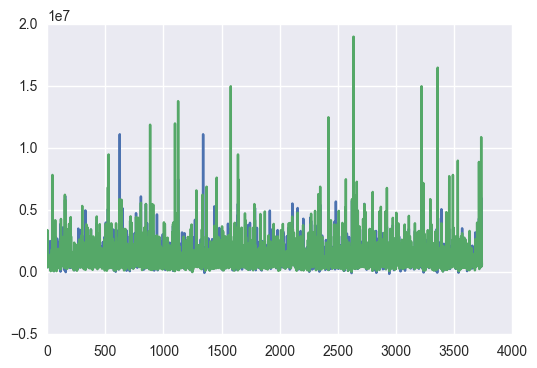

In [122]:
plt.figure()
plt.plot(clf.predict(X_test))
plt.plot(y_test)

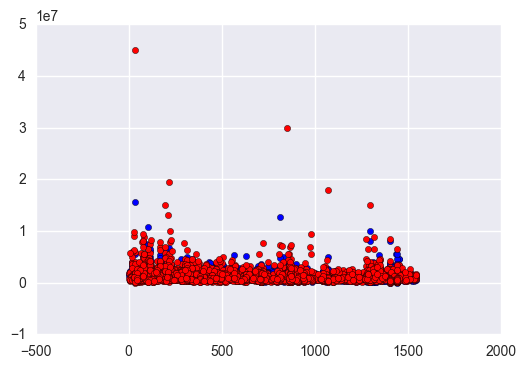

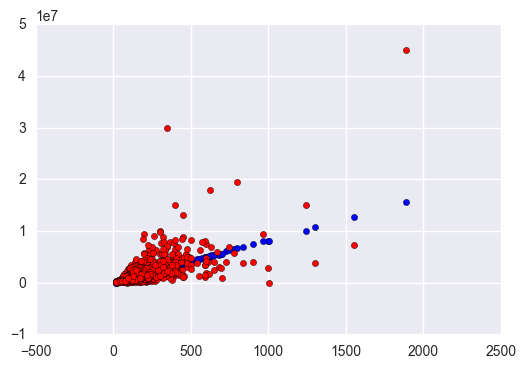

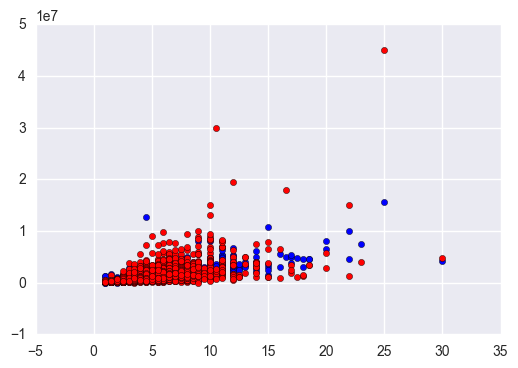

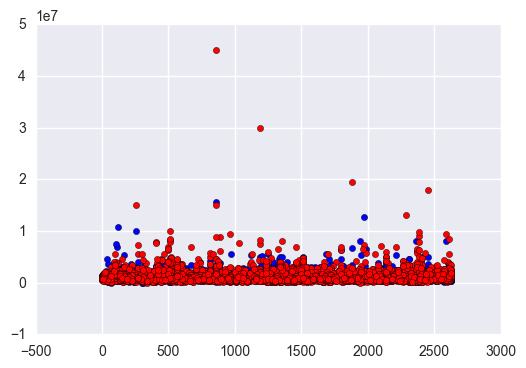

In [85]:
for col in X_test.T:
    plt.figure()
    plt.scatter(col,clf.predict(X_test))
    plt.scatter(col,y_test,c='red')

In [104]:
norm_sub.to_csv('regression_data.csv', index=False)

# Knn 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

# Keras 

In [105]:
pd.read_csv('regression_data.csv')

,agencyId,surfaceLiving,numberRooms,city,advertisementId,geo,geoLocation,price,norm_price,neighborhood_price,realvalue,Lon,Lat
0,r047,93.0,4.5,Aadorf,105968265,8048,"8.8953154,47.4942009",475000.0,5107.526882,NaN,NaN,8.895315,47.494201
1,ihg,118.0,4.5,Aadorf,105932380,8053,"8.8965341,47.4916938",495000.0,4194.915254,NaN,NaN,8.896534,47.491694
2,ihg,130.0,4.5,Aadorf,105932379,8052,"8.8964540,47.4916768",575000.0,4423.076923,NaN,NaN,8.896454,47.491677
3,trex,110.0,4.5,Aadorf,105914592,8082,"8.9018307,47.4894860",580000.0,5272.727273,NaN,NaN,8.901831,47.489486
4,trex,112.0,3.5,Aadorf,105914589,8082,"8.9018307,47.4894860",640000.0,5714.285714,NaN,NaN,8.901831,47.489486
5,ihg,152.0,4.5,Aadorf,105932375,8077,"8.9006126,47.4924564",665000.0,4375.000000,NaN,NaN,8.900613,47.492456
6,ihg,170.0,6.5,Aadorf,105947700,8047,"8.8952606,47.4912331",775000.0,4558.823529,NaN,NaN,8.895261,47.491233
7,x141,144.0,4.5,Aadorf,105730111,8046,"8.8949606,47.4936093",1020000.0,7083.333333,5390.977444,-1692.355890,8.894961,47.493609
8,trex,154.0,5.5,Aadorf,105914591,8082,"8.9018307,47.4894860",1210000.0,7857.142857,NaN,NaN,8.901831,47.489486
9,x366,196.0,5.5,Aadorf,105265991,8068,"8.8990398,47.4804808",1250000.0,6377.551020,NaN,NaN,8.899040,47.480481


In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using Theano backend.


In [176]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(10, input_dim=4, init='normal', activation='relu'))
	model.add(Dense(1, init='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [177]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=5, verbose=0)

In [178]:
kfold = KFold(n=len(X), n_folds=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyboardInterrupt: 

In [126]:
kfold = KFold(n=len(X), n_folds=10, random_state=seed)
results = cross_val_score(estimator, norm_X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 1636948891625.86 (508688078665.04) MSE
